In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [54]:
def get_psd(fname, data, plot=False):

    sig_bandpass = butter_bandpass_filter(data=data, lowcut=L_CUTOFF, highcut=H_CUTOFF, fs=F_S, order=B_ORDER)
    sig_cropped = crop_signal(sig_bandpass, window=300, intens_threshold=0.0004, offset=200)

    if sig_cropped is None or sig_cropped.empty:
        return pd.Series(np.ones(2500,)*np.nan)

    psd = psd_process(sig_cropped, fs=F_S, scaling='density', window='hamming', nperseg=256, noverlap=128+64, crop_hz=2500, nfft=8192)
    psd[fname] = psd.pow_amp
    return psd[fname]

def process_parallel(path):
    data, _ = read_simple([path])
    fname = path.split('/')[-1][:-4]
    return get_psd(fname, data)

def make_insect_df(insect_class='Culex'):
    print('Setting the number of cores..')
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 2   # arbitrary default

    print('Gathering all files for selected class..')
    wavhdlr = WavHandler('/home/yannis/data/insects/Potamitis/Wingbeats/{}'.format(insect_class), sample_size=1000, recursive=True)
    wavhdlr.read(create_table=True)
    names = wavhdlr.df_table.names.tolist()

    print('Creating pool for parallel processes..')
    pool = multiprocessing.Pool(processes=cpus)
    print('Calculating..')
    result_list = []
    result_list.append(pool.map(process_parallel, names))
    print('Creating Dataframe..')
    df = pd.concat(result_list[0], axis=1, sort=False)
    print('Done.\n')
    return df

In [44]:
df_an = make_insect_df(insect_class='Anopheles').T
df_an['label'] = 'an'
df_ae = make_insect_df(insect_class='Aedes').T
df_ae['label'] = 'ae'
df_cu = make_insect_df(insect_class='Culex').T
df_cu['label'] = 'cu'

Setting the number of cores..
Gathering all files for selected class..
Creating poll of processes..
Calculating..
Creating Dataframe..
Done.

Setting the number of cores..
Gathering all files for selected class..
Creating poll of processes..
Calculating..
Creating Dataframe..
Done.

Setting the number of cores..
Gathering all files for selected class..
Creating poll of processes..
Calculating..


/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 251, using nperseg = 251
  .format(nperseg, input_length))


Creating Dataframe..
Done.



In [45]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
print(df_concat.shape)
df_concat.head()
#df_concat.iloc[3,:-1].plot()

(3000, 2501)
(3000, 2501)


,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,label
F161212_194805_188_G_050,0.000285,0.000592,0.000656,0.000761,0.000905,0.001088,0.001305,0.001554,0.001831,0.002133,...,0.000798,0.000811,0.000825,0.000840,0.000855,0.000870,0.000886,0.000903,0.000920,ae
F170209_221218_019_G_050,0.009975,0.020357,0.021569,0.023569,0.026330,0.029810,0.033960,0.038721,0.044024,0.049794,...,0.000017,0.000017,0.000016,0.000016,0.000016,0.000015,0.000015,0.000014,0.000014,ae
F170301_142505_204_G_050_T_25.2_H_50.6,0.000665,0.001382,0.001535,0.001787,0.002135,0.002574,0.003096,0.003695,0.004361,0.005085,...,0.000140,0.000129,0.000119,0.000111,0.000104,0.000098,0.000092,0.000088,0.000084,ae
F170210_180002_001_G_050,0.010546,0.021459,0.022555,0.024366,0.026865,0.030016,0.033775,0.038089,0.042898,0.048134,...,0.000021,0.000021,0.000020,0.000020,0.000019,0.000019,0.000018,0.000018,0.000018,ae
F170206_211515_179_G_050,0.002410,0.004869,0.005012,0.005249,0.005577,0.005991,0.006486,0.007056,0.007693,0.008390,...,0.000094,0.000096,0.000097,0.000098,0.000100,0.000101,0.000102,0.000104,0.000105,ae


In [46]:
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')
df_mosquitos.set_index('fname', inplace=True)
print(df_mosquitos.shape)
df_mosquitos.tail(10)

(167725, 10)


,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,label1
fname,,,,,,,,,,
F170301_193157_020_G_050_T_25.9_H_56.0,0.032887,0.093844,0.001396,810.546875,1625.000000,2425.781250,0.040964,0.009014,0.010870,Aedes
F170301_193314_029_G_050_T_25.9_H_56.0,0.122471,0.086202,0.002711,764.648438,1562.500000,2289.062500,0.031290,0.022187,0.009812,Aedes
F170301_193417_033_G_050_T_25.9_H_56.0,0.127117,0.042620,0.000739,787.109375,1582.031250,2305.664062,0.031638,0.010802,0.007412,Aedes
F170301_193421_034_G_050_T_25.9_H_56.0,0.038245,0.012146,0.000624,728.515625,1417.968750,2151.367188,0.038204,0.025826,0.006809,Aedes
F170301_193636_042_G_050_T_25.9_H_56.5,0.111496,0.092593,0.001553,544.921875,1102.539062,1555.664062,0.049283,0.011957,0.010986,Aedes
F170301_193915_054_G_050_T_25.9_H_56.0,0.066598,0.136234,0.004561,527.343750,1052.734375,1562.500000,0.047222,0.027829,0.023750,Aedes
F170301_193916_055_G_050_T_25.9_H_56.0,0.113899,0.092764,0.032408,518.554688,1027.343750,1505.859375,0.048023,0.026141,0.020752,Aedes
F170301_194005_064_G_050_T_25.9_H_56.0,0.082995,0.010639,0.001265,811.523438,1614.257812,2411.132812,0.044525,0.016939,0.012961,Aedes
F170301_194043_070_G_050_T_25.9_H_56.5,0.096156,0.014383,0.001267,832.031250,1676.757812,2431.640625,0.036972,0.011066,0.007430,Aedes


In [47]:
df = pd.merge(df_mosquitos, df_concat, left_index=True, right_index=True)
df.drop(['label1'], axis=1, inplace=True)
df.to_pickle('./data/big_df.pkl')

In [48]:
#df.read_pickle('./data/big_df.pkl')

In [49]:
cols = df.columns.tolist()
labels = df.label.unique()
df.label.value_counts()

cu    664
ae    602
an    493
Name: label, dtype: int64

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(df.values[:,:-1], df.values[:,-1], random_state=0)
#del df


from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

After undersampling: 
cu    493
an    493
ae    493
Name: 0, dtype: int64

Name: XGBoost, ac: 0.756757


In [51]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                    index = cols[:-1],
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
pow2,0.033954
pow1,0.013874
damping_2,0.012413
0,0.009493
258,0.008397
369,0.007302
637,0.007302
1941,0.006207
damping_0,0.006207
damping_1,0.006207


In [52]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy based on 1 split of train/test: %.3f" %accuracy_score(y_test, y_pred))

[[68 18 20]
 [ 7 78  6]
 [17  4 78]]
Accuracy based on 1 split of train/test: 0.757


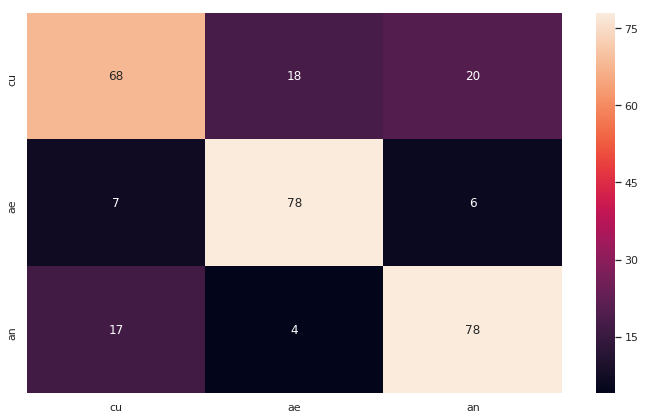

In [53]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
# Making a dataframe of the confusion matrix to plot it
df_cm = pd.DataFrame(cm, index=[i for i in labels], 
                    columns=[i for i in labels])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True, fmt='g')

plt.show()